In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from rlaopt.solvers import PCGConfig
from rlaopt.preconditioners import NystromConfig
from rlaopt.kernels import KernelConfig
from scalable_gp_inference.bayes_opt.configs import BayesOptConfig, TSConfig
from scalable_gp_inference.bayes_opt.core import BayesOpt

In [3]:
device = torch.device("cuda:1")
dtype = torch.float32
seed = 1

noise_variance = 1e-6
lengthscale = 0.5
pcg_iters = 10
kernel_type = "matern32"
n_steps = 2

In [4]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)

In [5]:
kernel_config = KernelConfig(const_scaling=1.0, lengthscale=0.5)

In [6]:
precond_config = NystromConfig(rank=100, rho=1e-6)

In [7]:
solver_config = PCGConfig(device=device, max_iters=pcg_iters, precond_config=precond_config, atol=1e-12, rtol=1e-12)

In [8]:
bayes_config = BayesOptConfig(kernel_config=kernel_config, kernel_type=kernel_type, noise_variance=noise_variance)

In [9]:
ts_config = TSConfig()

In [10]:
opt = BayesOpt(bayes_config, device=device, dtype=dtype)

In [ ]:
for _ in range(n_steps):
    opt.step(ts_config, solver_config)

forming linear system
solving linear system
solved linear system
getting acquisition points
got acquisition functions


In [ ]:
opt.bo_state

BayesOptState(X=tensor([[0.8903, 0.0275, 0.9031,  ..., 0.9047, 0.3370, 0.0347],
        [0.6334, 0.0201, 0.9307,  ..., 0.5992, 0.6501, 0.3025],
        [0.7642, 0.5446, 0.1114,  ..., 0.7429, 0.4303, 0.0995],
        ...,
        [0.9827, 0.0000, 0.1321,  ..., 1.0000, 0.9088, 0.4597],
        [0.0589, 1.0000, 0.2143,  ..., 0.2280, 0.9990, 0.0673],
        [0.0260, 0.2768, 0.6275,  ..., 0.0000, 0.8207, 0.2150]],
       device='cuda:1'), y=tensor([ 0.7093, -0.4982,  0.7995,  ...,  0.4701,  1.2483,  0.4890],
       device='cuda:1'), rf_obj=<scalable_gp_inference.random_features.RandomFeatures object at 0x7f5723e2b370>, w_true=tensor([-0.6340, -0.6431, -0.6420,  ...,  0.1254,  1.2263, -0.9960],
       device='cuda:1'), fn_max=3.9219515323638916, fn_argmax=51949)

In [ ]:
len(opt.bo_state)

52000

(array([ 37., 107., 323., 437., 472., 346., 192.,  67.,  15.,   4.]),
 array([-2.0102632 , -1.41704178, -0.82382023, -0.23059869,  0.36262274,
         0.95584416,  1.54906583,  2.14228702,  2.73550868,  3.32873034,
         3.92195153]),
 <BarContainer object of 10 artists>)

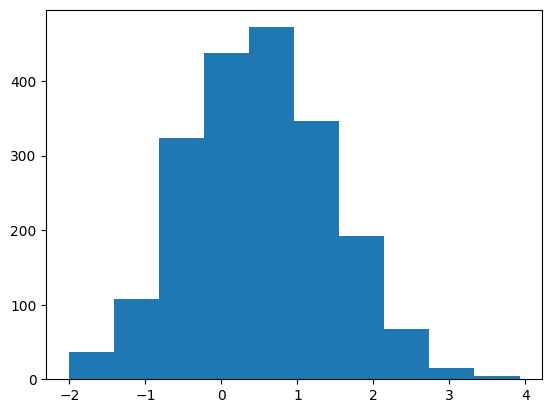

In [ ]:
import matplotlib.pyplot as plt

plt.hist(opt.bo_state.y[50000:].cpu().numpy())

In [ ]:
print(opt.bo_state.y[:50000].max())

tensor(3.8244, device='cuda:1')


In [ ]:
print(opt.bo_state.y[50000:].max())

tensor(3.9220, device='cuda:1')
